## Identify peaks per cluster

In [1]:
import numpy as np
import os
import sys
import logging
import collections
import matplotlib.pyplot as plt
import gzip
import glob
import loompy
import pybedtools
from pybedtools import BedTool
import MACS2
import multiprocessing as mp
from typing import *

sys.path.append('/home/camiel/chromograph/')
import chromograph
from chromograph.peak_calling.utils import *            
from chromograph.pipeline import config
from chromograph.peak_calling import call_MACS
import shutil

logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

from chromograph.pipeline import config
config = config.load_config()

# # Parameters
# ds = loompy.connect('/data/proj/scATAC/chromograph/build_20191206/Cerebellum.loom')
# logging.info(f'ds connection: {ds.shape}')

In [2]:
f = ['test', '/home/camiel/chromograph/notebooks/tmp/fragments_0.tsv.gz']
chromograph.peak_calling.utils.bed_downsample(f, 1e6)

18:08:45 INFO     cluster test has fraction: 0.07093095028038296
18:09:57 INFO     Total fragments: 14098218 in cluster test, downsampled to 998549


## Explore peaks

In [8]:
## Merge Peak lists
peakdir = '/data/proj/scATAC/chromograph/build_20200220_Midbrain/peaks/'

In [3]:
peaks = BedTool(os.path.join(peakdir, 'Compounded_peaks.bed'))
l = peaks.count()

logging.info(f'Length of the BedTools: {l}')

10:42:12 INFO     Length of the BedTools: 270213


In [14]:
import glob

counts = []
for f in glob.glob(os.path.join(peakdir, '*.tsv.gz')):
    p = BedTool(f)
    c = p.count()
    counts.append(c)
    print(f'{f.split("/")[-1]}, : {c}')

fragments_0.tsv.gz, : 28530865
fragments_1.tsv.gz, : 44668532
fragments_2.tsv.gz, : 51471900
fragments_3.tsv.gz, : 26781083
fragments_4.tsv.gz, : 31151164
fragments_5.tsv.gz, : 9572715
fragments_6.tsv.gz, : 18056227
fragments_7.tsv.gz, : 25675789
fragments_8.tsv.gz, : 17535199
fragments_9.tsv.gz, : 19542728
fragments_10.tsv.gz, : 30975204
fragments_11.tsv.gz, : 1455532


KeyboardInterrupt: 

In [32]:
2.5e7

25000000.0

In [32]:
## TEMPS
from chromograph.pipeline.utils import div0
tissues = ['Midbrain', 'Cerebellum']
files = [os.path.join(f'/data/proj/scATAC/chromograph/build_20200220_{x}', x + '_GA.loom') for x in tissues]
for f in files:
    with loompy.connect(f, 'r') as ds:
        GA_colsum = ds.map([np.count_nonzero], axis=1)[0]
        for (ix, selection, view) in ds.scan(axis=1):
            tmp = div0(div0(view[''][:,:], 1e-3 * ds.ra['BPs'].reshape(ds.shape[0], 1)), (1e-6 * GA_colsum[selection]))
            logging.info(f"FPKM for: {max(selection)} cells out of {ds.shape[1]}")
tmp

17:35:37 INFO     FPKM for: 511 cells out of 9452
17:35:37 INFO     FPKM for: 1023 cells out of 9452
17:35:38 INFO     FPKM for: 1535 cells out of 9452
17:35:38 INFO     FPKM for: 2047 cells out of 9452
17:35:39 INFO     FPKM for: 2559 cells out of 9452
17:35:39 INFO     FPKM for: 3071 cells out of 9452
17:35:40 INFO     FPKM for: 3583 cells out of 9452
17:35:40 INFO     FPKM for: 4095 cells out of 9452
17:35:41 INFO     FPKM for: 4607 cells out of 9452
17:35:41 INFO     FPKM for: 5119 cells out of 9452
17:35:42 INFO     FPKM for: 5631 cells out of 9452
17:35:42 INFO     FPKM for: 6143 cells out of 9452
17:35:43 INFO     FPKM for: 6655 cells out of 9452
17:35:43 INFO     FPKM for: 7167 cells out of 9452
17:35:43 INFO     FPKM for: 7679 cells out of 9452
17:35:44 INFO     FPKM for: 8191 cells out of 9452
17:35:44 INFO     FPKM for: 8703 cells out of 9452
17:35:45 INFO     FPKM for: 9215 cells out of 9452
17:35:45 INFO     FPKM for: 9451 cells out of 9452
17:35:59 INFO     FPKM for: 511 

array([[ 0.        ,  0.        ,  7.90904772, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 13.74600376, ...,  0.        ,
         0.        ,  6.5824624 ],
       ...,
       [ 0.        ,  0.        ,  2.99093965, ...,  0.        ,
         4.03221569,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.24996198,  0.        ,  1.29367517, ...,  0.        ,
         0.        ,  1.85848229]])

In [4]:
f_annot = os.path.join(peakdir, 'annotated_peaks.txt')
cols, table = read_HOMER_annotation(f_annot)
table.shape

(270213, 21)

In [7]:
peak_IDs = np.array([x[3] for x in peaks])

table = reorder_by_IDs(table, peak_IDs)

In [8]:
## Save as dict    
annot = {cols[i]: table[:,i] for i in range(table.shape[1])}

In [44]:
annot

{'ID': array(['chr1:28958-29333', 'chr1:180967-181164', 'chr1:181357-181709',
        ..., 'chrY:56839027-56839223', 'chrY:56842612-56842884',
        'chrY:56855817-56856007'], dtype=object),
 'Chr': array(['chr1', 'chr1', 'chr1', ..., 'chrY', 'chrY', 'chrY'], dtype=object),
 'Start': array(['28959', '180968', '181358', ..., '56839028', '56842613',
        '56855818'], dtype=object),
 'End': array(['29333', '181164', '181709', ..., '56839223', '56842884',
        '56856007'], dtype=object),
 'Strand': array(['+', '+', '+', ..., '+', '+', '+'], dtype=object),
 'Peak Score': array(['.', '.', '.', ..., '.', '.', '.'], dtype=object),
 'Focus Ratio/Region Size': array(['NA', 'NA', 'NA', ..., 'NA', 'NA', 'NA'], dtype=object),
 'Annotation': array(['promoter-TSS (ENST00000473358.1)', 'Intergenic', 'Intergenic',
        ..., 'Intergenic', 'Intergenic', 'TTS (ENST00000431853.1)'],
       dtype=object),
 'Detailed Annotation': array(['lincRNA-promoter-TSS (ENST00000473358.1)', 'Intergenic',
   

In [10]:
r_dict = {k: v for v,k in enumerate(annot['ID'])}

In [11]:
simple_annotation = np.array([x.split(' ')[0] for x in annot['Annotation']])

counts = {}
for x in np.unique(simple_annotation):
    counts[x] = np.sum(simple_annotation == x)
    
print(counts)

{'Intergenic': 92716, 'TTS': 8049, 'exon': 12630, 'intron': 139889, 'promoter-TSS': 16929}


In [9]:
# def Count_peaks(cells, sample_dir, f_peaks):
#     '''
#     Count peaks
#     '''
#     Count_dict = {k: {} for k in cells}
#     peaks = BedTool(f_peaks)
#     i = 0
#     for x in cells:
#         try:
#             s, c = x.split(':')
#             f = os.path.join(sample_dir, s, 'fragments', f'{c}.tsv.gz')
#             cBed = BedTool(f)
#             pks = peaks.intersect(cBed, wa=True)

#             cDict = {}
#             for line in pks:
#                 cDict[line[3]] = 1

#             Count_dict[x] = cDict
#             i += 1
#             if i%1000==0:
#                 logging.info(f'Finished counting {i} cells')
#         except:
#             Count_dict[x] = []
#     logging.info('Finished job')
#     return Count_dict

# Count_dict1 = Count_peaks(ds.ca['CellID'][:10], config.paths.samples, fpeaks)
# Count_dict2 = Count_peaks(ds.ca['CellID'][10:20], config.paths.samples, fpeaks)
# Count_dict3 = Count_peaks(ds.ca['CellID'][20:30], config.paths.samples, fpeaks)
# dicts = [Count_dict1, Count_dict2, Count_dict3]
# Counts = {k: v for d in dicts for k, v in d.items()}

In [12]:
# from scipy import sparse
# logging.info("Generating Sparse matrix")
# col = []
# row = []
# v = []

# cix = 0
# for cell in ds.ca['CellID'][:30]:

#     for key in (Counts[cell]):
#         col.append(cix)
#         row.append(r_dict[key])
#         v.append(Counts[cell][key])
#     cix+=1
# matrix = sparse.coo_matrix((v, (row,col)), shape=(len(r_dict.keys()), len(ds.ca['CellID'][:30])))

# ## Create loomfile
# logging.info("Constructing loomfile")
# floom = f'{ds.filename.split(".")[0]}_peaks.loom'

# loompy.create(filename=floom, 
#               layers=matrix, 
#               row_attrs=annot, 
#               col_attrs=dict(ds.ca),
#               file_attrs=dict(ds.attrs))
# self.loom = floom
# logging.info("Loom peaks file saved as {}".format(floom))

10:43:33 INFO     Generating Sparse matrix


NameError: name 'Counts' is not defined

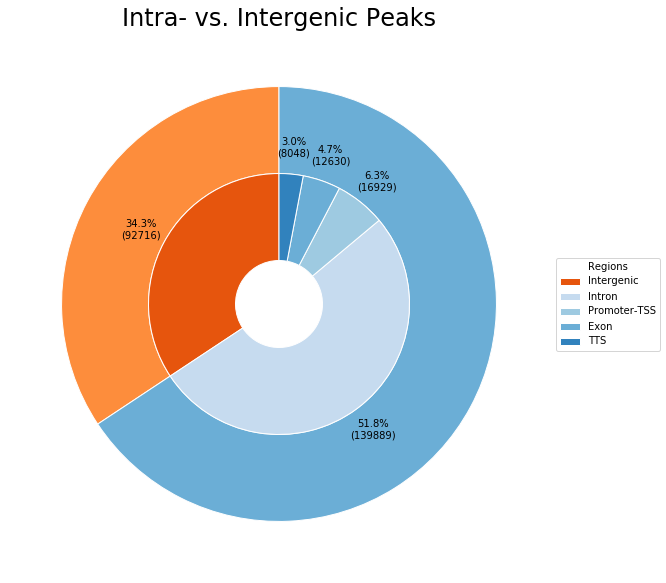

In [38]:
labels = 'Intergenic', 'Intron', 'Promoter-TSS', 'Exon', 'TTS'

fig, ax = plt.subplots(figsize = (12,10))
plt.rcParams["font.size"] = "10"

size = 0.4
vals = np.array([counts['Intergenic'], counts['intron'], counts['promoter-TSS'], counts['exon'], counts['TTS']])

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(2)*4 + 1)[[1,0],:]
inner_colors = cmap(np.array([0,1,2,3,4]))[::-1,:]

ax.pie([vals[0], sum(vals[1:])], radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'), startangle=90)

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

wedges, texts, autotexts = ax.pie(vals.flatten(), radius=1-size, colors=inner_colors, autopct=lambda pct: func(pct, vals), pctdistance=1.2, 
       wedgeprops=dict(width=size, edgecolor='w'), startangle=90)

ax.set(aspect="equal")
ax.set_title('Intra- vs. Intergenic Peaks', fontsize=24)

ax.legend(wedges, labels,
          title="Regions",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.savefig('/data/proj/scATAC/chromograph/tmp/Midbrain_peaks.png')
plt.show()

In [21]:
peak_list = BedTool([(annot['Chr'][x], str(annot['Start'][x]), str(annot['End'][x]), str(annot['ID'][x])) for x in range(len(annot['Chr']))]).saveas()

for x in ['tss', 'transcripts', 'promoter', 'enhancer', 'dnase', 'ctcf', 'blacklist']:
    sub = BedTool(os.path.join(config.paths.ref, 'regions', f'{x}.bed'))
    peak_list = peak_list.subtract(sub, A=True)
    
for x in ['regulatory.gff', 'genes.gtf']:
    sub = BedTool(os.path.join(config.paths.ref, 'genes', x))
    peak_list = peak_list.subtract(sub, A=True)
    
peak_list.saveas()
print(peak_list.count())

22786


In [22]:
unknown_peaks = [x[3] for x in peak_list]

In [24]:
regs = []
nPeaks = len(annot['Annotation'])
for i in range(len(annot['Annotation'])):
    
    if annot['ID'][i] in unknown_peaks:
        regs.append(annot['Annotation'][i])

    if i%100000 == 0:
        logging.info(f'Finished {i} out of {nPeaks}')
unknown_annotation = np.array([x.split(' ')[0] for x in regs])

11:02:33 INFO     Finished 0 out of 270213
11:02:58 INFO     Finished 100000 out of 270213
11:03:24 INFO     Finished 200000 out of 270213


In [25]:
unk_counts = {}
for x in np.unique(unknown_annotation):
    unk_counts[x] = np.sum(unknown_annotation == x)
    
print(unk_counts)

{'Intergenic': 21954, 'TTS': 550, 'promoter-TSS': 282}


In [26]:
unk_counts['Intergenic'] / counts['Intergenic']

0.23678760947409294

## Find Differentially accessible regions for the identified clusters